In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    # For GPU 0
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    memory_used = info.used
    # For GPU 1
    handle = nvmlDeviceGetHandleByIndex(1)
    info = nvmlDeviceGetMemoryInfo(handle)
    memory_used += info.used
    print(f"GPU memory occupied: {memory_used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()


print_gpu_utilization()

GPU memory occupied: 1278 MB.


In [3]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased").to('cuda:0')
print_gpu_utilization()

/home/zonghang/.conda/envs/accelerate/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a 

GPU memory occupied: 3219 MB.


In [4]:
default_args = {
    "output_dir": "outputs",
    "evaluation_strategy": "no",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [5]:
import numpy as np
from datasets import Dataset

seq_len, dataset_size = 512, 512
dummy_data = {
    "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(0, 1, (dataset_size)),
}
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")

# Optimizer
The most common optimizer used to train transformer model is **Adam** or **AdamW** (Adam with weight decay). Adam achieves good convergence by storing the rolling average of the previous gradients which, however, **adds an additional memory footprint of the order of the number of model parameters**.

One remedy to this is to use an alternative optimizer such as **Adafactor**, which works well for some models but still has instability issues.

On the other hand [**8bit BNB optimizer**](https://github.com/TimDettmers/bitsandbytes) can save 3/4 of memory normally used by a typical AdamW optimizer if it is configured to quantize all optimizer states, but in some situations only some optimizer states are quintized and then more memory is used.

Let’s get a feel for the numbers and use for example use a **3B-parameter model, like t5-3b**. Note that since a Gigabyte correpsonds to a billion bytes we can simply multiply the parameters (in billions) with the number of necessary bytes per parameter to get Gigabytes of GPU memory usage:

* A standard **AdamW** uses 8 bytes for each parameter, here the optimizer will need (8*3) **24GB** of GPU memory.
* **Adafactor** uses slightly more than 4 bytes, so (4*3) **12GB** and then some extra.
* **8bit BNB quantized optimizer** will use only (2*3) **6GB** if all optimizer states are quantized.

Let’s have a look at Adafactor first.

## Adafactor
Instead of keeping the rolling average for each element, **Adafactor only stores aggregated information (row- and column-wise sums of the rolling averages) which reduces the footprint considerably**.

One downside of Adafactor is that, in some instances, **convergence can be slower than Adam’s**, so some experimentation is advised here.

We can use Adafactor simply by setting <code>optim="adafactor"</code>:

In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    per_device_train_batch_size=4, 
    optim="adafactor", 
    **default_args
)

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=ds
)

result = trainer.train()

print_summary(result)

Step,Training Loss


Time: 43.82
Samples/second: 11.69
GPU memory occupied: 10440 MB.


Here we compare the results with the vanilla training.

* Time: 40.96 (Increase to 43.82 seconds)
* Samples/second: 12.50 (Decrease to 11.69 samples per second)
* GPU memory occupied: 12852 MB **(Decrease to 10440 MB)**

We can see that this saves a few more GB on the GPU. 

Let’s see how it looks when we add it to the other methods we introduced earlier:

In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    optim="adafactor",
    **default_args,
)

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=ds
)

result = trainer.train()

print_summary(result)

Step,Training Loss


Time: 42.19
Samples/second: 12.14
GPU memory occupied: 5142 MB.


Here we compare the results with the one with only the adafactor optimizer enabled:

* Time: 43.82 **(Decrease to 42.19 seconds)**
* Samples/second: 11.69 **(Increase to 12.14 samples per second)**
* GPU memory occupied: 10440 MB. **(Decrease to 5142 MB)**

Here we compare the results with the one only enabing gradient accumulation, checkpointing, and mixed precision training:

* Time: 39.06 (Increase to 42.19 seconds)
* Samples/second: 13.11 (Decrease to 12.14 samples per second)
* GPU memory occupied: 7574 MB **(Decrease to 5142 MB)**

We went from 10 GB memory usage to 5 GB - a **2x improvement in memory while maintaining the throughput!**

However, as mentioned before, the **convergence of Adafactor can be worse than Adam**.

So we have seen how we can optimize the memory footprint of large models. The following plot summarizes all our experiments (from Hugging Face):

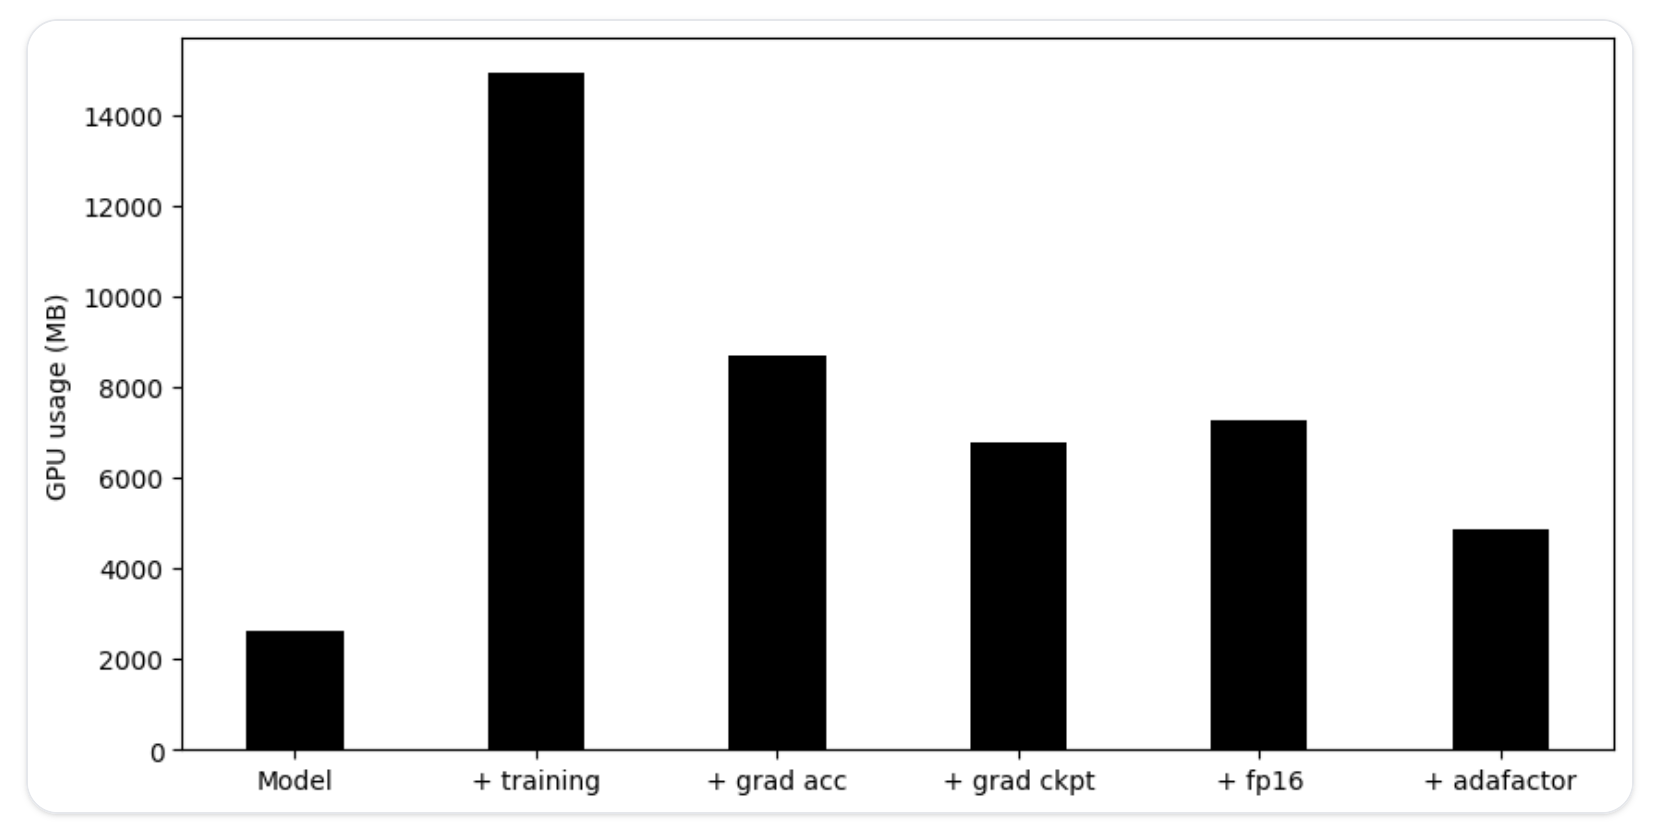